# Flujo Monofásico en 2D con SciPy

**Objetivo general**
- El alumno resolverá la ecuación de Laplace en dos dimensiones, la cual representa el flujo monofásico incompresible en estado estable, con propiedades del fluido y del medio constantes. Mediante la solución de esta ecuación, se conocerán los tipos de condiciones de frontera y los tipos de solvers que se aplican en la solución de problemas relacionados con la Simulación Matemática de Yacimientos (SMY).

**Objetivos particulares**
- Conocer los diferentes tipos de "solvers" para los sistemas de ecuaciones lineales.
- Identificar la dirección del flujo de fluidos de acuerdo a las isobaras.

## Contenido
- [1 - Implementación de SciPy](#1)
    - [1.1 - ](#3.1)
    - [Ejercicio 1](#ej-1)

# 1 Implementación de SciPy

La  biblioteca de scipy permite utilizar una basta cantidad de algoritmos, solvers y funciones cientificas. El uso de éstas logra resolver el problema cientifico en mucho menos tiempo. Como alternativa al algoritmo de Thomas, se plantea el uso de los siguientes solvers:
- spsolve
- cg
- bicgstab
- gmres

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import funciones_personalizadas as fp

from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
from scipy.sparse.linalg import cg
from scipy.sparse.linalg import gmres
from scipy.sparse.linalg import bicgstab

In [7]:
def ecuaciones_discretizadas(lx, ly, nodosx_Int, nodosy_Int, hx, hy):
    """
    Esta funcion genera los coeficientes de la ecuacion de flujo monofasico discretizada. No se consideran las
    condiciones de frontera.
    Parametros
    ----------
    lx, ly : entero o flotante.
        Longitud en el eje x e y.
    nx, ny : int, int.
        Nodos en de la malla rectangular.
    Retorna
    -------
    AP,AE,AW,AN,AS,B : ndarray. 
        Arreglos en 2D para generar una matriz pentadiagonal.
    """
    
    # se definen los arreglos en dos dimensiones
    AP = np.zeros((nodosx_Int, nodosy_Int)) 
    AE = np.zeros((nodosx_Int, nodosy_Int))
    AW = np.zeros((nodosx_Int, nodosy_Int))
    AN = np.zeros((nodosx_Int, nodosy_Int))
    AS = np.zeros((nodosx_Int, nodosy_Int))
    B = np.zeros((nodosx_Int, nodosy_Int))
    
    for j in range (0,nodosy_Int):
        for i in range (0,nodosx_Int):
            AP[i][j]=2.0/hx**2.0+2.0/hy**2.0
            AE[i][j]=1.0/hx**2.0
            AW[i][j]=1.0/hx**2.0
            AN[i][j]=1.0/hy**2.0
            AS[i][j]=1.0/hy**2.0
            B[i][j]=0.0

    return AP,AE,AW,AN,AS,B

In [8]:
def condiciones_de_frontera_dirichlet(P1, P2, P3, P4, AP, AW, AE, AN, AS, B, nodosx_Int, nodosy_Int):
    """
    Esta función modifica los coeficientes y asigna las condiciones de frotera de primera clase. 
    """
    for i in range (1,nodosx_Int-1):
            
        #Frontera sur sin considerar los nodos esquina o que coinciden con 2 condiciones de frontera
        B[i][0]=AS[i][0]*P2
        AS[i][0]=0.0
        
        #Frontera norte sin considerar los nodos esquina o que coinciden con 2 condiciones de frontera
        B[i][nodosy_Int-1]=AN[i][nodosy_Int-1]*P4
        AN[i][nodosy_Int-1]=0.0

    for j in range (1,nodosy_Int-1):

        #Frontera oeste sin considerar los nodos esquina o que coinciden con 2 condiciones de frontera
        B[0][j]=AW[0][j]*P1
        AW[0][j]=0.0

        #Frontera este sin considerar los nodos esquina o que coinciden con 2 condiciones de frontera
        B[nodosx_Int-1][j]=AE[nodosx_Int-1][j]*P3
        AE[nodosx_Int-1][j]=0.0
        
    #Nodo esquina inferior izquierda, coordenada (1,1) según el diagrama que considera todos los nodos
    B[0][0]=AW[0][0]*P1+AS[0][0]*P2  #(0,0) porque estamos trabajando con los nodos internos 

    #Nodo esquina superior izquierda, coordenada (1,ny-2) según el diagrama que considera todos los nodos
    B[0][nodosy_Int-1]=AW[0][nodosy_Int-1]*P1+AN[0][nodosy_Int-1]*P4  #(0,nodosy_Int-1) porque estamos trabajando con los nodos internos 
    
    #Nodo esquina inferior derecha, coordenada (nx-2,1) según el diagrama que considera todos los nodos
    B[nodosx_Int-1][0]=AE[nodosx_Int-1][0]*P3+AS[nodosx_Int-1][0]*P2  #(nodosx_Int-1,0) porque estamos trabajando con los nodos internos 

    #Nodo esquina superior derecha, coordenada (nx-2,ny-2) según el diagrama que considera todos los nodos
    B[nodosx_Int-1][nodosy_Int-1]=AE[nodosx_Int-1][nodosy_Int-1]*P3+AN[nodosx_Int-1][nodosy_Int-1]*P4  #(nodosx_Int-1,nodosy_Int-1) porque estamos trabajando con los nodos internos 
    

### Uso de SciPy

In [23]:
def flujo_monofasico_2d_scipy(nx, ny, lx, ly):
    """
    Esta función resuelve el problema de flujo monofásico en 2D con ayuda de la libreria SciPy y sus solvers.  
    """
    
    """
        |---P4(NORTE)---|
        |               |
    P1(OESTE)        P3(ESTE)
        |               |
        |----P2(SUR)----|
    """

    P1, P2, P3, P4  = 1000.0, 500.0, 500.0, 500.0
    Press= np.zeros((nx,ny))

    #Generación de malla para graficar
    x = np.linspace(0, lx, nx)
    y = np.linspace(0, ly, ny)
    malla_x, malla_y = np.meshgrid(x, y)
    
    # se calcula el espaciamiento entre nodos
    hx = lx/(nx-1)
    hy = ly/(ny-1)
    
    nodosx_Int, nodosy_Int = nx-2, ny-2
    
    # Llamar a la función para obtener los coeficientes
    AP, AW, AE, AN, AS, B = ecuaciones_discretizadas(lx, ly, nodosx_Int, nodosy_Int, hx, hy)

    #Aplicar condiciones de frontera
    condiciones_de_frontera_dirichlet(P1, P2, P3, P4, AP, AW, AE, AN, AS, B, nodosx_Int, nodosy_Int)
    
    n = nodosx_Int*nodosy_Int
    A = np.zeros((n,n))  #Matriz de coeficientes A
    p = np.zeros(n)      #Vector incognita
    b = np.zeros(n)      #Vector conocido o lado derecho (RHS)
    
    Press = np.zeros((nx, ny))  #Presión en todo el dominio discreto (incluyendo las fronteras)
    PressInt = np.zeros((nodosx_Int, nodosy_Int)) #Presión en los nodos internos (excluyendo las fronteras)

    #Construcción de la matriz densa A
    for j in range (0,nodosy_Int):
        for i in range (0,nodosx_Int):
            k=i+nodosx_Int*j     
            A[k][k] = AP[i][j]
            b[k] = B[i][j]
        
            if j < nodosy_Int-1: A[k][k+nodosx_Int] = -AN[i][j]
            if i < nodosx_Int-1: A[k][k+1] = -AE[i][j]
            if i > 0: A[k][k-1] = -AW[i][j]
            if j > 0: A[k][k-nodosx_Int] = -AS[i][j]    
    
    
    A1 = lil_matrix(A)  #A1 es un matriz tipo lista que se crea a partir de la matriz densa A
    A1 = A1.tocsr()     #La matriz A1 se pasa a formato compressed storage row (filas compridas) para utilizar los solvers

    p = spsolve(A1, b)  #scipy.sparse.linalg.gmres(A, b, x0=None, tol=1e-05, restart=None, maxiter=None, xtype=None, M=None, callback=None, restrt=None)[source]¶
    #p = cg(A1, b, tol=1.0E-07)  #scipy.sparse.linalg.gmres(A, b, x0=None, tol=1e-05, restart=None, maxiter=None, xtype=None, M=None, callback=None, restrt=None)[source]¶
    #p = bicgstab(A1, b, tol=1.0E-07)  #scipy.sparse.linalg.gmres(A, b, x0=None, tol=1e-05, restart=None, maxiter=None, xtype=None, M=None, callback=None, restrt=None)[source]¶
    #p = gmres(A1, b, tol=1.0E-07, restart = 2000)  #scipy.sparse.linalg.gmres(A, b, x0=None, tol=1e-05, restart=None, maxiter=None, xtype=None, M=None, callback=None, restrt=None)[source]¶

    #pasamos los resultados a una matriz de presiones de los nodos internos
    for j in range (0,nodosy_Int):
        for i in range (0,nodosx_Int):
            k=i+j*nodosx_Int
#             PressInt[i][j]=p[0][k]    #Cuando se utilizan los algoritmos del subespacio de Krilov el resultado es una matriz de tamaño 1 X nx*ny
            PressInt[i][j]=p[k]    #Cuando se utiliza spsolve (descomposición LU) el resultado es un vector de tamaño 1 X nx*ny
   

    #llenado de la matriz de presión en todo el dominio 
    
    #Paso 1: Pasar las presiones calculadas correspondientes a los nodos internos
    for j in range (1,ny-1):
        for i in range (1,nx-1):
            Press[i][j]=PressInt[i-1][j-1]
    
    #Paso 2: Colocar las fronteras conocidas
    for i in range (1,nx):
        Press[i][0]=P2     #Frontera sur
        Press[i][ny-1]=P4  #Frontera norte
     
    for j in range (0,ny):
        Press[0][j]=P1    #Frontera oeste
        Press[nx-1][j]=P3  #Frontera este
        
    # graficar
    fp.graficar_isobaras_presion_y_campo_velocidad(nx, ny, hx, hy, malla_x, malla_y, Press)

In [25]:
nx, ny = 50, 50
lx, ly = 500, 500

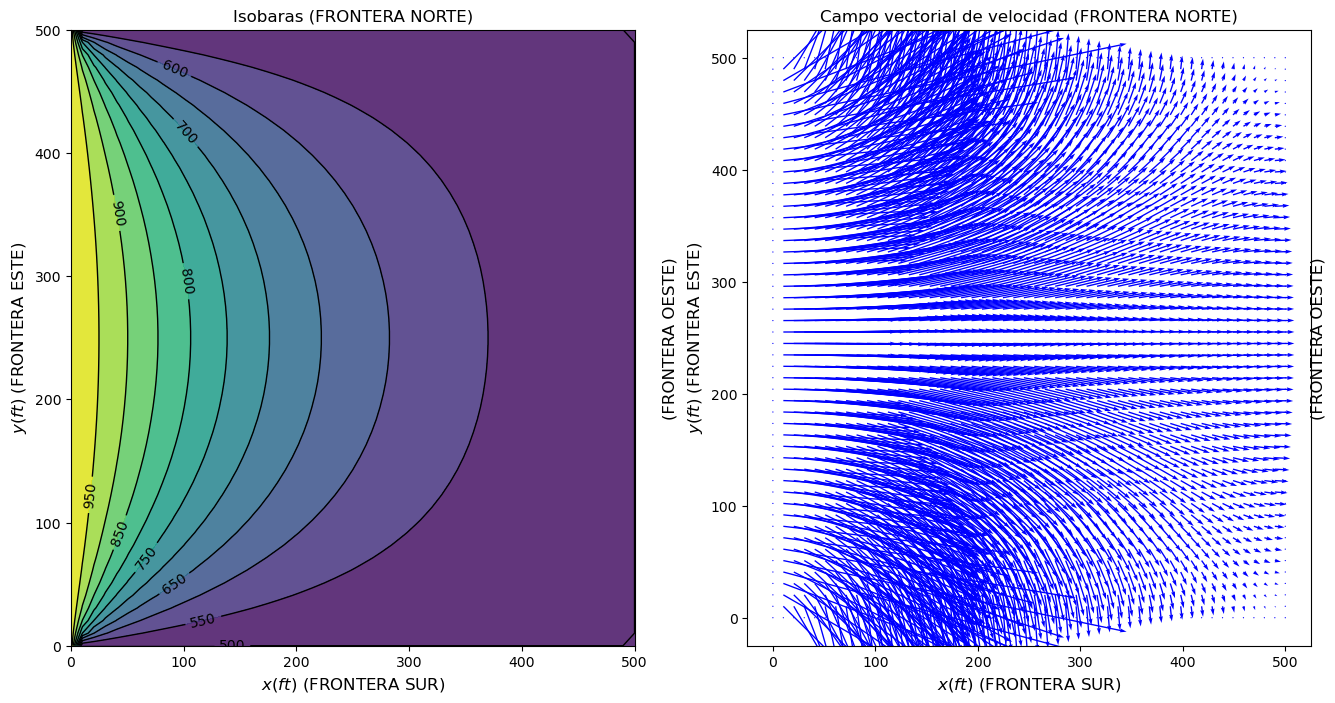

CPU times: total: 531 ms
Wall time: 571 ms


In [26]:
%%time
flujo_monofasico_2d_scipy(nx, ny, lx, ly)

## Ejercicio 3 - Uso de SciPy

En el script **widgets.interact(flujo_monofasico_2d_scipy_animacion, presion_cambiante = widgets.Play(min=600, max=1000))**:

    1.- Cambia el rango de presiones desde 750 psi a 1,400 psi.

En el script **flujo_monofasico_2d_scipy_animacion(presion_cambiante)**:

    2.- Asigna la variable --> presion_cambiante a P3 y el resto de presiones con el valor de 600 psi.
    
    3.- Comenta las lineas de codigo pertenecientes al solver gmres --> p = gmres(A1, b, tol=1.0E-07, restart = 2000) y --> PressInt[i][j]=p[0][k]
    
    4.- Descomenta las lineas de codigo pertenecientes a spsolve --> p = spsolve(A1, b) y --> PressInt[i][j]=p[k]

    5.- Ejecuta las celdas de codigo modificada, visualiza los resultados y compara los tiempos de computo mediante una tabla.